# Question 1: Multi Layer Perceptron


## Task :

<ul>
<li>Train MLP for MNIST</li>
<li>Knowledge Distillation</li>
</ul>


# Data Preprocessing


<img src="Images/Q4-prep.png" width = 500>


In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# PyTorch for Deep Learning
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# TensorFlow and Keras for Deep Learning
import tensorflow as tf
from tensorflow import keras

# scikit-learn for clustering
from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score

import seaborn as sns
import torchvision


### 1. Load data set / report the number and dimensions of training and test data


In [10]:

transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

train_dataset = torchvision.datasets.MNIST(
    root='./data', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=64, shuffle=True)

test_dataset = torchvision.datasets.MNIST(
    root='./data', train=False, transform=transform, download=True)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=64, shuffle=False)


In [11]:
num_train_samples = len(train_dataset)
train_data_dimensions = train_dataset[0][0].shape

num_test_samples = len(test_dataset)
test_data_dimensions = test_dataset[0][0].shape

print("Training Data:")
print(f"Number of Samples: {num_train_samples}")
print(f"Data Dimensions: {train_data_dimensions}")

print("\nTest Data:")
print(f"Number of Samples: {num_test_samples}")
print(f"Data Dimensions: {test_data_dimensions}")


Training Data:
Number of Samples: 60000
Data Dimensions: torch.Size([1, 28, 28])

Test Data:
Number of Samples: 10000
Data Dimensions: torch.Size([1, 28, 28])


### 2. Show an example of each class


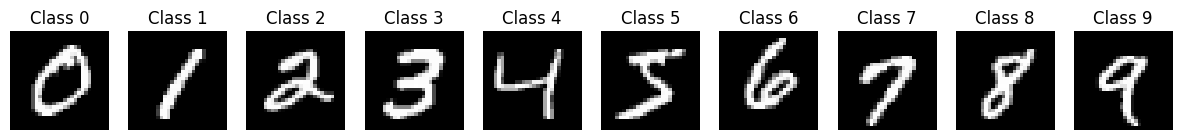

In [16]:

class_shown = {}

fig, axs = plt.subplots(1, 10, figsize=(15, 2))

for i in range(len(train_dataset)):
    image, label = train_dataset[i]
    label = int(label)
    if label not in class_shown:
        ax = axs[label]
        ax.imshow(image[0], cmap='gray')
        ax.set_title(f'Class {label}')
        ax.axis('off')
        class_shown[label] = True

    if len(class_shown) == 10:
        break

plt.show()


### 3. Draw histogram chart for training data


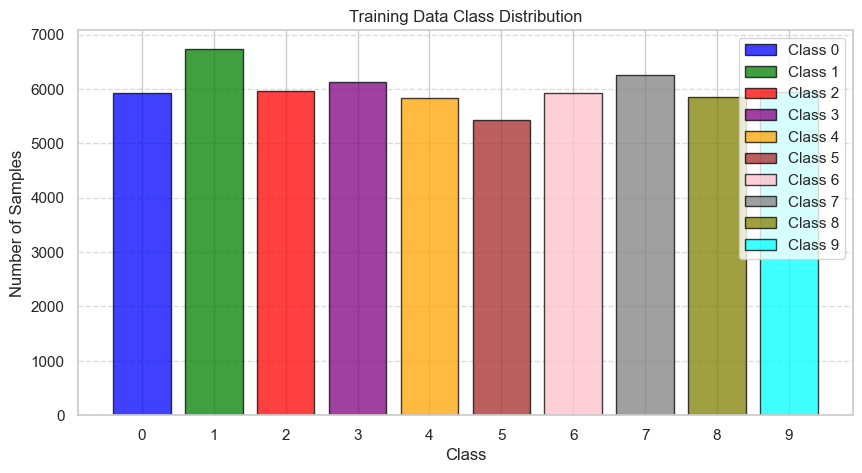

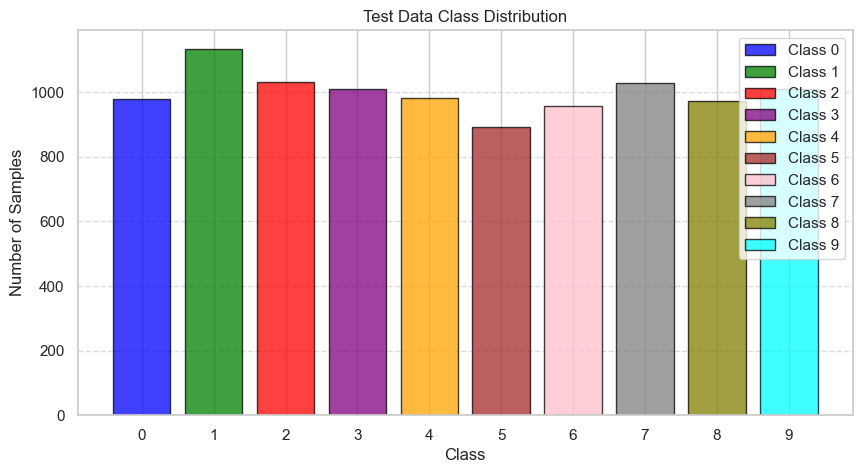

In [19]:
colors = ['blue', 'green', 'red', 'purple', 'orange',
          'brown', 'pink', 'gray', 'olive', 'cyan']


def plot_class_histogram(dataset, title):
    labels = [int(label) for _, label in dataset]
    unique_labels = list(set(labels))

    plt.figure(figsize=(10, 5))
    for i, label in enumerate(unique_labels):
        color = colors[i % len(colors)]
        plt.hist(
            [label for label in labels if label == unique_labels[i]],
            bins=[unique_labels[i] - 0.5, unique_labels[i] + 0.5],
            align='mid',
            rwidth=0.8,
            alpha=0.75,
            edgecolor='black',
            color=color,
            label=f'Class {unique_labels[i]}'
        )

    plt.xticks(range(10))
    plt.xlabel("Class")
    plt.ylabel("Number of Samples")
    plt.title(title)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(loc='best')


# Plot the histogram for the training data
plot_class_histogram(train_dataset, title="Training Data Class Distribution")
plt.show()

# Plot the histogram for the test data
plot_class_histogram(test_dataset, title="Test Data Class Distribution")
plt.show()


### 4. Scaling using min-max normalization


In [24]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Lambda(
        lambda x: (x - x.min()) / (x.max() - x.min()))
])

train_dataset_normalized = torchvision.datasets.MNIST(
    root='./data', train=True, transform=transform, download=True)
train_loader_normalized = torch.utils.data.DataLoader(
    train_dataset_normalized, batch_size=64, shuffle=True)

test_dataset_normalized = torchvision.datasets.MNIST(
    root='./data', train=False, transform=transform, download=True)
test_loader_normalized = torch.utils.data.DataLoader(
    test_dataset_normalized, batch_size=64, shuffle=False)


---


## Teacher Network


In [27]:
class Teacher(nn.Module):
    def __init__(self):
        super(Teacher, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(784, 1024)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(1024, 512)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(512, 10)
        self.relu3 = nn.ReLU()

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        return x


In [28]:
teacher = Teacher()


In [30]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(teacher.parameters(), lr=0.01)

# Training parameters
batch_size = 32
num_epochs = 20

# Data loaders
train_loader = torch.utils.data.DataLoader(
    train_dataset_normalized, batch_size=batch_size, shuffle=True)

# Lists to store training history
train_loss_history = []
train_accuracy_history = []

# Training loop
for epoch in range(num_epochs):
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = teacher(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = (correct_predictions / total_samples) * 100

    train_loss_history.append(train_loss)
    train_accuracy_history.append(train_accuracy)

    print(
        f'Epoch [{epoch + 1}/{num_epochs}] - Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%')


Epoch [1/20] - Loss: 1.0458, Accuracy: 75.39%
Epoch [2/20] - Loss: 0.3488, Accuracy: 90.11%
Epoch [3/20] - Loss: 0.2853, Accuracy: 91.82%
Epoch [4/20] - Loss: 0.2455, Accuracy: 92.95%
Epoch [5/20] - Loss: 0.2143, Accuracy: 93.93%
Epoch [6/20] - Loss: 0.1889, Accuracy: 94.66%
Epoch [7/20] - Loss: 0.1679, Accuracy: 95.18%
Epoch [8/20] - Loss: 0.1502, Accuracy: 95.68%
Epoch [9/20] - Loss: 0.1360, Accuracy: 96.09%
Epoch [10/20] - Loss: 0.1238, Accuracy: 96.47%
Epoch [11/20] - Loss: 0.1123, Accuracy: 96.81%
Epoch [12/20] - Loss: 0.1033, Accuracy: 97.09%
Epoch [13/20] - Loss: 0.0949, Accuracy: 97.31%
Epoch [14/20] - Loss: 0.0876, Accuracy: 97.56%
Epoch [15/20] - Loss: 0.0812, Accuracy: 97.76%
Epoch [16/20] - Loss: 0.0753, Accuracy: 97.91%
Epoch [17/20] - Loss: 0.0698, Accuracy: 98.08%
Epoch [18/20] - Loss: 0.0650, Accuracy: 98.22%
Epoch [19/20] - Loss: 0.0607, Accuracy: 98.39%
Epoch [20/20] - Loss: 0.0567, Accuracy: 98.47%


#### save / load model


In [32]:

model_path = 'teacher_model.pth'
torch.save(teacher.state_dict(), model_path)


In [33]:
loaded_teacher = Teacher()
loaded_teacher.load_state_dict(torch.load(model_path))
loaded_teacher.eval()


Teacher(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=1024, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=512, out_features=10, bias=True)
  (relu3): ReLU()
)

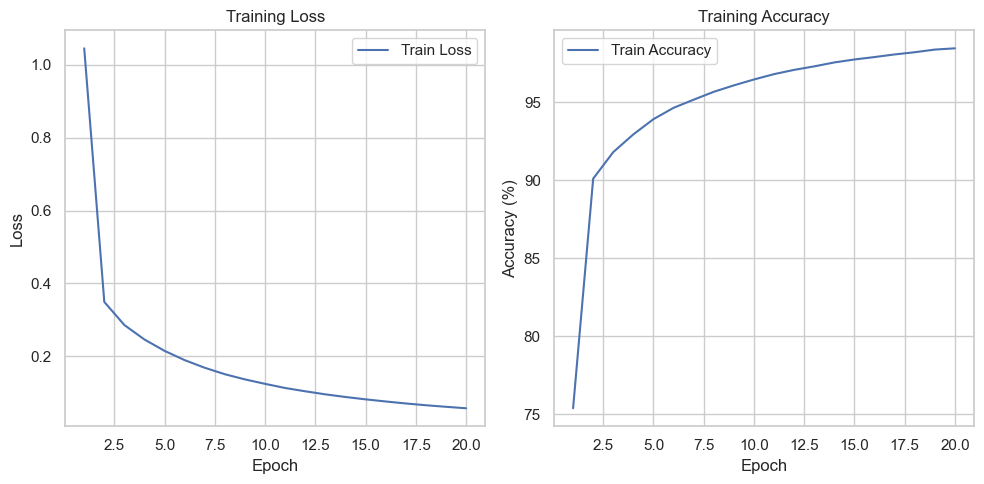

In [34]:

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_loss_history, label='Train Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1),
         train_accuracy_history, label='Train Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()


#### logit:

To find the class predicted by network from the logit output in PyTorch, we can use the `torch.max(output.data,1)` function. The mentioned function will find index of maximum value among the class scores of the output values and retun predicted class.

`The accurac`y is division of number of correct answers per total samples.

`The miss-classification` is difference total number of samples and the correct predictions.


In [36]:
teacher.eval()
correct_predictions = 0
total_samples = 0

with torch.no_grad():
    for inputs, labels in test_loader_normalized:
        outputs = teacher(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

test_accuracy = (correct_predictions / total_samples) * 100

print(f'Test Accuracy: {test_accuracy:.2f}%')

# Calculate the number of misclassifications
misclassifications = total_samples - correct_predictions
print(f'Number of Misclassifications: {misclassifications}')


Test Accuracy: 97.52%
Number of Misclassifications: 248
